START OF THE FINAL PROJECT

All of the import statements

In [10]:
import pandas as pd
import transformers
from torch import torch_version
from torch import nn
import torch
import lyricsgenius
from tqdm import tqdm
import numpy as np

1)LOAD THE DATASET

In [11]:
import pandas as pd
import string
import re 
# from config import CONFIG



class PREPROCESS:
    def __init__(self) -> None:
        df = pd.read_csv("output_csv_file.csv")
        df["prepText"] = df["Lyrics"].apply(self.cleanString)
        df = df[["Artist", "Title", "prepText","Label"]]
        # save the file 
        df.to_csv("preprocessed_songs_gram.csv", index=False)
    
    def cleanString(self,sentence):
        sentence = sentence.translate(str.maketrans("","", string.punctuation)).strip().lower()
        sentence = re.sub(r"https?://\s+", "", sentence)
        sentence = re.sub(r"\b\d+\b",  "", sentence)
        sentence = re.sub(r" +"," ",sentence).replace("\n", " ").replace("\r", "").replace("\r\n", "")
        sentence = re.sub("\s+", " ", sentence)
        return sentence    




In [12]:
PREPROCESS()


In [13]:
from sentence_transformers import SentenceTransformer

import os
import numpy as np
from tqdm import tqdm
# import faiss
class findEmbedding:
    def __init__(self) -> None:
        self.df = pd.read_csv("preprocessed_songs_gram.csv")
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        embeddings = self.computeEmbeddings()
        if not os.path.isdir("results"):
            os.mkdir("results")
        PATH = os.path.join("embedding.npy")
        with open( PATH, "wb") as fp:
            np.save(fp, embeddings)

    def computeEmbeddings(self):
        sentences = self.df["prepText"].values
        embeddings = []
        for sentence in tqdm(sentences):
            embedding = self.model.encode(sentence)
            embeddings.append(embedding)
        return np.array(embeddings)

In [14]:
findEmbedding()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 773/773 [00:15<00:00, 49.86it/s] 


In [15]:
import faiss
class recmmSystem:
    def __init__(self) -> None:
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.df = pd.read_csv("preprocessed_songs.csv")
        PATH = os.path.join( "embedding.npy")
        embeddings = np.load(PATH)
        dimension = embeddings.shape[1]
        quantize = faiss.IndexFlatL2(dimension)
        self.index = faiss.IndexIVFFlat(quantize, dimension, 50)

        if not self.index.is_trained:
            print(1)
            self.index.train(embeddings)
        
        if self.index.is_trained:
            print(0)
            self.index.add(embeddings)

        print("Total Number of embeddings index {}".format(self.index.ntotal))
    
    def nearestNeighbour(self, query, k):
        queryEmbeddings = self.model.encode([query])
        D, I = self.index.search(queryEmbeddings, k)
        artist_songs = dict()
        allRelatable = self.df.iloc[I[0]]
        for index, rows in allRelatable.iterrows():
            print(rows["artist"])
            artist_songs[rows["artist"]] = rows["song"]
        
        print("Query: ", query)
        print(artist_songs)
findEmbedding()
recmmSystem()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 773/773 [00:06<00:00, 111.13it/s]


1
0
Total Number of embeddings index 773


WARNING clustering 773 points to 50 centroids: please provide at least 1950 training points


In [17]:
from pyechonest import catalog
cat = catalog.Catalog('CACNYVZ1332EB0BA9D')
cat.read()

TabError: inconsistent use of tabs and spaces in indentation (catalog.py, line 327)

In [18]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

class fs_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(fs_model, self).__init__()
        self.relu = nn.ReLU()  
        self.sigmoid = nn.Sigmoid();
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        # x = torch.round(x)
        return x


In [19]:
import json,os
i = 0
labels = []
for filename in os.listdir("results"):
    if i>6:
        break
    i+=1
    with open(f"results/{filename}","r") as file:
        data = json.load(file)
        for song in data:
            labels.append(song["Label"])
labels = [element.rstrip("\n") for element in labels] 
labels = labels[:251]

labels = [int(element) for element in labels]
print(labels)    


[]


In [20]:
import optuna
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from  tqdm import tqdm
import json

# with open('user_4_songs.json', 'r') as file:
#     data_dict = json.load(file)
num_users = 1  # Change this to the number of users you have
user_embeddings = torch.eye(num_users)  # Create one-hot encoded tensors for users

embeddings = np.load("embedding_lyrics_total.npy")

loss_func  = nn.BCEWithLogitsLoss()

embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)
user_tensors_tensor = torch.tensor(user_embeddings, dtype=torch.float32)
labels_tensor = torch.tensor(labels,dtype=torch.float32).unsqueeze(1)
input_tensor = torch.cat((user_tensors_tensor.repeat(len(labels), 1), embeddings_tensor), dim=1)
input_size = input_tensor.shape[1]
losses = []
def training(model, train_loader, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
            losses.append(loss)
            if len(losses) == 0:
                losses.append(loss)
            # print('Epoch {}, Batch {}, Loss {}'.format(epoch, batch_idx, loss.item()))

        return model
best_model = None
def testing(model, loss_function, test_data):
    global best_loss, best_model
    '''
    This function will test the given model on the given test_data
    it will return the accuracy and the test loss (given by loss_function)
    '''
    sum_loss = 0
    for batch_idx, (data, target) in enumerate(test_data):         
    
        pred = model(data)
        loss = loss_function(pred,target )
        sum_loss += loss.item()
    
    print(len(test_data))
    avg_loss = round(sum_loss / len(test_data), 2)
    if avg_loss < best_loss:
    
       best_loss = avg_loss
       best_model = model
        
    
    print("test loss:", best_model )
    return best_loss,best_model


        # print('Accuracy on test set: {}%'.format(100*correct/total))
accuracies = []
model = None
best_loss = 1000000
b_loss = 100000
def objective(trial):
    global model,b_loss
    hidden_dim = trial.suggest_int('hidden_dim', 50, 200)
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = 100

    model = fs_model(input_size,hidden_dim,1)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    dataset = TensorDataset(input_tensor, labels_tensor)
    data_train, data_test = torch.utils.data.random_split(dataset, [211, 40])
    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

    trained_model = training(model, train_loader, optimizer, num_epochs)
    test_loss,best_model = testing(trained_model,loss_func,test_loader)
    print("Test loss is ", test_loss)
    if test_loss < b_loss:
    
        b_loss = test_loss
        best_model = model
    
    # model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            # print(data, 'data')
            # print(output, 'output')
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    return accuracy



study = optuna.create_study(direction='maximize')


study.optimize(objective, n_trials=100)


best_params = study.best_params
best_accuracy = study.best_value

single_embedding = embeddings[0]
single_embedding = np.append(single_embedding, 1)
embeddings_tensor = torch.tensor(single_embedding, dtype=torch.float32)
# input_tensor = torch.cat((user_tensors_tensor.repeat(len(labels), 1), embeddings_tensor), dim=1)

# dataset = TensorDataset(input_tensor, labels_tensor)

# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)



# embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)
# user_tensors_tensor = torch.tensor(user_tensors, dtype=torch.float32)
# labels_tensor = torch.tensor(labels, dtype=torch.float32)
# input_tensor = torch.cat((user_tensors_tensor.repeat(len(labels), 1), embeddings_tensor), dim=1)

# with torch.no_grad():
#     for data, target in train_loader:
#         model(data)
final_output = best_model(embeddings_tensor).item()


print(final_output)



print("Best parameters:", best_params)
print("Best validation accuracy:", best_accuracy)
# losses = [loss.detach().numpy() for loss in losses]
losses = [float(element) for element in losses]
print(losses)
plt.plot(losses)
plt.xlabel('N_epochs')
plt.ylabel('Losses')
plt.title('Plot of Values')
plt.show()
print(best_params["hidden_dim"])
new_model = fs_model(input_size,2000,output_dim=1)


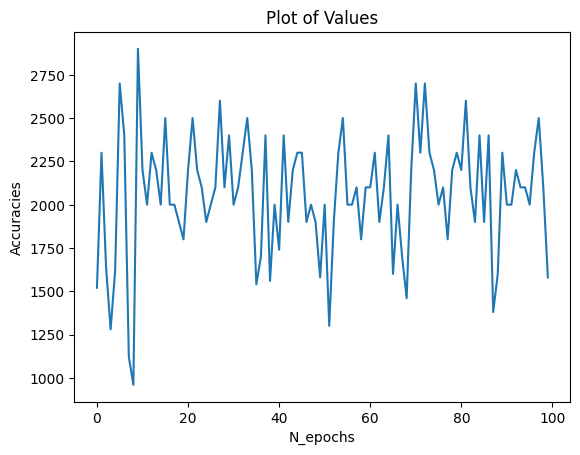

In [ ]:
plt.plot(accuracies)
plt.xlabel('N_epochs')
plt.ylabel('Accuracies')
plt.title('Plot of Values')
plt.show()

In [72]:
from tkinter import *
from tkinter import ttk
import customtkinter

customtkinter.set_appearance_mode("System")
customtkinter.set_default_color_theme("blue")

import sv_ttk


songs_dict = {}
def get_lyrics(song_name, artist_name):
    try:
        dict_return = {}
        token = "3A0e7egqWm6omWk78xEe72UGXSUGNTiIVhTz81_Sq1pQc6ob_8642ZHCcmPC67WW"
        genius = lyricsgenius.Genius(token)
        
        artist = genius.search_song(song_name, artist_name)
        dict_return[song_name] = artist.lyrics
        return dict_return
    except:
        return "No lyrics found"
f_num = 5
h_num = 5


def get_user_input():
    
    app = customtkinter.CTk()
    app.title("Spotify Song Recommender")
    app.geometry("880x420")  
    left_frame = customtkinter.CTkFrame(master= app, width= 200, height= 400, corner_radius=12)
    left_frame.grid(row=0, column=0, padx=10, pady=5)
    left_frame.grid_propagate(False)

    right_frame = customtkinter.CTkFrame(master= app, width= 650, height= 400, corner_radius=12)
    right_frame.grid(row=0, column=1, padx=10, pady=5)
    right_frame.grid_propagate(False)


    # image = PhotoImage(file="spotify.png")
    # original_image = image.subsample(3,3)
    # Label(left_frame, image=original_image).grid(row=1, column=0, padx=5, pady=5)

    liked = customtkinter.CTkFrame(master= left_frame, width= 180, height= 180, corner_radius=12)
    disliked = customtkinter.CTkFrame(master= left_frame, width= 180, height= 180, corner_radius=12)
    liked.grid(row=0, column=0, padx=5, pady=5)
    disliked.grid(row=1, column=0, padx=5, pady=5)

    Label(liked, text="Liked songs:").grid(row=0, column=0, padx=5, pady=5)
    Label(disliked, text="Disliked songs:").grid(row=0, column=0, padx=5, pady=5)


    Label(right_frame, text="Enter liked songs:").grid(row=0, column=0, padx=5, pady=5)
    liked_entry = customtkinter.CTkEntry(right_frame, placeholder_text="Enter a liked song", width= 600)
    liked_entry.grid(row=1, column=0, columnspan=2, padx=(20, 0), pady=(20, 20), sticky="nsew")

    Label(right_frame, text="Enter disliked songs:").grid(row=2, column=0, padx=5, pady=5)
    disliked_entry = customtkinter.CTkEntry(right_frame, placeholder_text="Enter a disliked song", width= 600)
    disliked_entry.grid(row=3, column=0, columnspan=2, padx=(20, 0), pady=(20, 20), sticky="nsew")
    # tool_bar = Frame(left_frame, width=180, height=185)
    # tool_bar.grid(row=2, column=0, padx=5, pady=5)

    # Label(tool_bar, text="Tools", relief=RAISED).grid(row=0, column=0, padx=5, pady=3, ipadx=10)
    # Label(tool_bar, text="Filters", relief=RAISED).grid(row=0, column=1, padx=5, pady=3, ipadx=10)

    # Label(tool_bar, text="Select").grid(row=1, column=0, padx=5, pady=5)
    # Label(tool_bar, text="Crop").grid(row=2, column=0, padx=5, pady=5)
    # Label(tool_bar, text="Rotate & Flip").grid(row=3, column=0, padx=5, pady=5)
    # Label(tool_bar, text="Resize").grid(row=4, column=0, padx=5, pady=5)
    # Label(tool_bar, text="Exposure").grid(row=5, column=0, padx=5, pady=5)
    liked = []
    disliked = []

    
    app.mainloop()

    return liked.append(disliked)


    # list_return = []
    # global f_num,h_num
    # for i in range(f_num):
    #     try:
    #         f_input = input("Input your favorite song(include artists after comma)")
    #         f_list = f_input.split(",")
    #         songs_dict = get_lyrics(f_list[0], f_list[1])
            
    #         list_return.append(songs_dict)
    #     except:
    #         print("Song not found,try again")
    #         f_num+=1
        
    # for i in range(h_num):
    #     try:

    #         h_input = input("Input your hated songs (include artists after comma): ")
            
    #         h_list = h_input.split(",")
    #         songs_dict = get_lyrics(h_list[0], h_list[1])
    #         list_return.append(songs_dict)
    #     except:
    #         print("Song not found,try again")
    #         h_num+=1
    # return list_return
returned_list = get_user_input()

In [4]:
from tkinter import *
from tkinter import ttk
import customtkinter

customtkinter.set_appearance_mode("System")
customtkinter.set_default_color_theme("blue")


def submit_song():
    like = liked_entry.get()
    dislike = disliked_entry.get()

    liked_entry.delete(0, 'end')
    disliked_entry.delete(0, 'end')

    l_list = like.split(",")
    d_list = dislike.split(",")

    liked_list.append(get_lyrics(l_list[0], l_list[1]))
    disliked_list.append(get_lyrics(d_list[0], d_list[1]))


    Label(liked, text=l_list[0]).grid(row=len(liked_list), column=0, padx=5, pady=5)
    Label(disliked, text=d_list[0]).grid(row=len(liked_list), column=0, padx=5, pady=5)

    if (len(liked_list) == 5):
        print("UMS")
        returned_list.append(liked)
        returned_list.append(disliked)
        song_button.config(state=DISABLED)



app = customtkinter.CTk()
app.title("Spotify Song Recommender")
app.geometry("880x420")  
left_frame = customtkinter.CTkFrame(master= app, width= 200, height= 400, corner_radius=12)
left_frame.grid(row=0, column=0, padx=10, pady=5)    
left_frame.grid_propagate(False)

right_frame = customtkinter.CTkFrame(master= app, width= 650, height= 400, corner_radius=12)
right_frame.grid(row=0, column=1, padx=10, pady=5)
right_frame.grid_propagate(False)


liked = customtkinter.CTkFrame(master= left_frame, width= 180, height= 180, corner_radius=12)
disliked = customtkinter.CTkFrame(master= left_frame, width= 180, height= 180, corner_radius=12)
liked.grid(row=0, column=0, padx=5, pady=5)
disliked.grid(row=1, column=0, padx=5, pady=5)

Label(liked, text="Liked songs:").grid(row=0, column=0, padx=5, pady=5)
Label(disliked, text="Disliked songs:").grid(row=0, column=0, padx=5, pady=5)


Label(right_frame, text="Enter liked songs:").grid(row=0, column=0)
liked_entry = customtkinter.CTkEntry(right_frame, placeholder_text="Input your liked songs (include artists after comma): ", width= 600)
liked_entry.grid(row=1, column=0, columnspan=2, padx=(20, 0), pady=(20, 20), sticky="nsew")

Label(right_frame, text="Enter disliked songs:").grid(row=2, column=0)
disliked_entry = customtkinter.CTkEntry(right_frame, placeholder_text="Input your hated songs (include artists after comma): ", width= 600)
disliked_entry.grid(row=3, column=0, columnspan=2, padx=(20, 0), pady=(20, 20), sticky="nsew")

song_button = customtkinter.CTkButton(right_frame, text="Submit song", command=submit_song)
song_button.grid(row=4, column=0, columnspan=2, padx=(20, 0), pady=(20, 20), sticky="nsew")

Label(right_frame, text="Recommendation:").grid(row=5, column=0)

liked_list = []
disliked_list = []
returned_list = []
       
def get_everything_together(songs_dict):
    if songs_dict is None:#if it is a premade
        songs_dict = get_user_input()
    
    findEmbedding(dictionary=songs_dict,name="test")
    t_model = few_shot_train()
    recc = search_songs(t_model)
    Label(liked, text=recc).grid(row=6, column=0, padx=5, pady=5)

    
app.mainloop()   

invalid command name "4385300096update"
    while executing
"4385300096update"
    ("after" script)
invalid command name "4390360640check_dpi_scaling"
    while executing
"4390360640check_dpi_scaling"
    ("after" script)


In [ ]:
from sentence_transformers import  SentenceTransformer
import os
class findEmbedding:
    def __init__(self,dictionary,name) -> None:
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        embeddings = self.computeEmbeddings(dictionary)

        PATH = os.path.join(f"{name}.npy")
        with open( PATH, "wb") as fp:
            np.save(fp, embeddings)

    def computeEmbeddings(self,dictionary):
        embeddings = []


        
        for song in dictionary:
            sentence = list(song.keys())
            sentence = song[sentence[0]]
            
            embeddings.append(self.model.encode(sentence))

                # Increment the file counter
                
        return np.array(embeddings)

In [ ]:
findEmbedding(returned_list,"test")


In [ ]:
from torch import optim
def few_shot_train():
    embeddings_few_shot = np.load("test.npy")
    print(embeddings_few_shot.shape)
    label_few_shot = [1,1,1,1,1,0,0,0,0,0]
    ones_column = torch.ones((1, 1))  # Create a column of ones
    # Create a dataset for user feedback
    dataset = [(embedding, label) for embedding, label in zip(embeddings_few_shot, label_few_shot)]
    # Fine-tune the pre-trained model on user feedback
    fine_tune_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    fine_tune_epochs = 100  # Adjust the number of fine-tuning epochs as needed
    optimizer = optim.Adam(best_model.parameters(), lr=1)
    for epoch in range(fine_tune_epochs):
        for data, target in fine_tune_loader:
            optimizer.zero_grad()
            data = torch.tensor(data,dtype=torch.float32)
            embeddings_with_ones = torch.cat((data, ones_column), dim=1)
            target = torch.tensor(target,dtype=torch.float32)
            output = model(embeddings_with_ones)
            output = output.squeeze(1)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
    return model
    

# Evaluate the fine-tuned model
# test_loss, test_accuracy = testing(model, loss_func, test_loader)

In [ ]:
test = {}

test["I wanna be yours"] = get_lyrics("Swim","Chase Atlantic")
findEmbedding(dictionary=test,name="test")

NameError: name 'get_lyrics' is not defined

In [ ]:
import random
random.randint(1,54)
def search_songs(input_model):
    songs_found = {}
    r = random.randint(0,54)
    for filename in os.listdir("results"):
        
        with open(f"results/user_{r}_songs.json", 'r', encoding='utf-8', newline='') as file:
            data = json.load(file)
            for obj in data:
               song_title = obj["Title"]
               song_artist = obj["Artist"]
               
               dict_found = get_lyrics(song_title,song_artist)
               if dict_found == "No lyrics found":
                   continue
                
               dict_found =[dict_found]
               findEmbedding(dictionary=dict_found,name="test")
               embeddings = np.load("test.npy")
               embeddings = torch.tensor(embeddings)
               ones_column = torch.ones((1, 1))
               test_embeddings = torch.cat((embeddings, ones_column), dim=1)


               score = input_model(test_embeddings)
               score = score.item()

               if score>0.48:
                   l= dict_found[0]
                   return list(l.keys())[0]
                   
            else:
                continue
    return songs_found

In [ ]:
import os
import faiss
import pandas as pd
from sentence_transformers import SentenceTransformer
from pprint import pprint
class recmmSystem:
    def __init__(self) -> None:
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.df = pd.read_csv("spotify_millsongdata.csv")
        PATH = os.path.join("embedding_lyrics_total.npy")
        embeddings = np.load(PATH)
        dimension = embeddings.shape[1]
        quantize = faiss.IndexFlatL2(dimension)
        self.index = faiss.IndexIVFFlat(quantize, dimension, 50)

        if not self.index.is_trained:
            self.index.train(embeddings)
        
        if self.index.is_trained:
            # let's add this 
            self.index.add(embeddings)

        print("Total Number of embeddings index {}".format(self.index.ntotal))
    
    def nearestNeighbour(self, query, k):
        # we can now search 
        queryEmbeddings = self.model.encode([query])
        D, I = self.index.search(queryEmbeddings, k)
        # let's get the index result 
        artist_songs = dict()
        allRelatable = self.df.iloc[I[0]]
        for index, rows in allRelatable.iterrows():
            artist_songs[rows["artist"]] = rows["song"]
        
        print("Query: ", query)
        pprint(artist_songs)


In [ ]:
system = recmmSystem()
system.nearestNeighbour(list(songs_dict.keys())[0])

NameError: name 'recmmSystem' is not defined

EVERYTHING TOGETHER

In [2]:
def everything_together(songs_dict):
    if songs_dict is None:#if it is a premade
        songs_dict = get_user_input()
    
    findEmbedding(dictionary=songs_dict,name="test")
    t_model = few_shot_train()
    print("5 SONGS I LIKE")
    for i in returned_list[:5]:
         print(f"\n{list(i.keys())[0]}")
    print("5 SONGS I DO NOT LIKE")
    for i in returned_list[5:]:
        print(f"\n{list(i.keys())[0]}")
    print("Song that you need to listen next is",search_songs(t_model))

    
everything_together(None)
    

NameError: name 'get_user_input' is not defined

In [73]:
import tkinter as tk


song_arr = []

shown = False

def song_list():
    if shown:
        shown = True
    else:
        shown = False
    
    if shown:
        song_list.config(text=f"{song_arr}!")
    else:
        song_list.config(text="")


def submit_song():
    song = entry.get()
    if song in song_arr:
        songs_2.config(text=f"{song} is already in list!")
    else:
        song_arr.append(song)
    if song:
        song_list.config(text=f"{song_arr}!")
    else:
       song_list.config(text="Input some songs")


root = tk.Tk()
root.title("Spotify Song Recommender")


entry = tk.Entry(root, width=30)
entry.pack(pady=10)

song_button = tk.Button(root, text="Submit song", command=submit_song)
song_button.pack()

list_button = tk.Button(root, text="Show song list", command=song_list)
list_button.pack()

song_list = tk.Label(root, text="")

songs = tk.Label(root, text="Songs:")
songs_2 = tk.Label(root, text="")
song_list = tk.Label(root, text="")

songs.pack()
songs_2.pack()
song_list.pack(pady=10)


root.mainloop()

In [ ]:


print(embeddings)

[[-0.06669568 -0.09863818  0.04980293 ... -0.00151163  0.05756469
  -0.05387075]
 [-0.06669568 -0.09863818  0.04980293 ... -0.00151163  0.05756469
  -0.05387075]
 [-0.06669568 -0.09863818  0.04980293 ... -0.00151163  0.05756469
  -0.05387075]
 ...
 [-0.06669568 -0.09863818  0.04980293 ... -0.00151163  0.05756469
  -0.05387075]
 [-0.06669568 -0.09863818  0.04980293 ... -0.00151163  0.05756469
  -0.05387075]
 [-0.06669568 -0.09863818  0.04980293 ... -0.00151163  0.05756469
  -0.05387075]]
